In [ ]:
import os

os.chdir("D:/kaggle_d/SenNet_HOA_Hacking_the_Human_Vasculature_in3D/kaggle")

In [2]:
import json
import pandas as pd
import numpy as np
import numexpr as ne
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb
from dotenv import load_dotenv
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.cuda.amp as amp

from src.model.model import save_model, load_inference_model
from src.dataset.df import df_dataset, check_dataset
from src.utils.common import set_seed

from src.experiment.inference import inference
from src.experiment.initialize import init_dataset, init_model, init_exp
from src.utils.metrics import compute_surface_dice_score_from_volume
from src.model.model import build_model
from src.model.loss import get_lossfn
from src.utils.metrics import get_metrics
from src.model.scheduler import get_scheduler
from src.dataset.common import get_train_dataset

In [6]:
class cfg:
    debug = False
    check_dataset = False

    # = data CFG ====================================================

    dataset_path = "working/dataset/train01_xy_256_128_z_1_2/"
    train_dataset = "Base2dDataset"
    negative_sample_rate = 0.2

    # = experiment CFG =================================================

    project = "SenNet"
    exp_name = os.path.basename(os.getcwd())
    notes = "base exp014"

    # = model CFG ======================================================

    model_arch = "Unet"
    backbone = "resnext101_32x8d"
    in_chans = 1
    target_size = 1

    # = training CFG ===================================================

    epochs = 20

    train_batch_size = 64
    valid_batch_size = train_batch_size

    loss = "DiceLoss"
    metrics = "Dice"
    lr = 5e-4
    num_workers = 12

    # = augmentation ===================================================

    image_size = 256
    train_aug = [
        A.RandomRotate90(p=0.5),
        A.RandomGamma(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomResizedCrop(image_size, image_size, scale=(0.8, 1)),
        A.ShiftScaleRotate(p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug = [
        ToTensorV2(transpose_mask=True),
    ]

    # =============== inference ========================================

    test_dataset = "BaseInferenceDataset"
    stride = image_size // 2
    drop_egde_pixel = 32


load_dotenv("key.env")
set_seed()

/tmp/ipykernel_1538/2551012421.py:18: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{cfg.dataset_path}/dataset.csv")


,image_path,label_path,fname,kidney,x,y,z,std,sum,fold0,fold1,axis
0,/kaggle/working/dataset/cropped_xy_256_128_z_1...,/kaggle/working/dataset/cropped_xy_256_128_z_1...,x0_y0_z0_std0039_sum0,kidney_1_dense,0,0,0,39,0,valid,train,axis0
1,/kaggle/working/dataset/cropped_xy_256_128_z_1...,/kaggle/working/dataset/cropped_xy_256_128_z_1...,x0_y0_z100_std0037_sum0,kidney_1_dense,0,0,100,37,0,valid,train,axis0
2,/kaggle/working/dataset/cropped_xy_256_128_z_1...,/kaggle/working/dataset/cropped_xy_256_128_z_1...,x0_y0_z102_std0036_sum0,kidney_1_dense,0,0,102,36,0,valid,train,axis0
3,/kaggle/working/dataset/cropped_xy_256_128_z_1...,/kaggle/working/dataset/cropped_xy_256_128_z_1...,x0_y0_z104_std0036_sum0,kidney_1_dense,0,0,104,36,0,valid,train,axis0
4,/kaggle/working/dataset/cropped_xy_256_128_z_1...,/kaggle/working/dataset/cropped_xy_256_128_z_1...,x0_y0_z106_std0036_sum0,kidney_1_dense,0,0,106,36,0,valid,train,axis0
...,...,...,...,...,...,...,...,...,...,...,...,...
158709,/kaggle/working/dataset/cropped_xy_256_128_z_1...,/kaggle/working/dataset/cropped_xy_256_128_z_1...,x256_y896_z990_std0224_sum1278,kidney_3_sparse,256,896,990,224,1278,train,NaN,axis0
158710,/kaggle/working/dataset/cropped_xy_256_128_z_1...,/kaggle/working/dataset/cropped_xy_256_128_z_1...,x256_y896_z992_std0226_sum1334,kidney_3_sparse,256,896,992,226,1334,train,NaN,axis0
158711,/kaggle/working/dataset/cropped_xy_256_128_z_1...,/kaggle/working/dataset/cropped_xy_256_128_z_1...,x256_y896_z994_std0228_sum1362,kidney_3_sparse,256,896,994,228,1362,train,NaN,axis0
158712,/kaggle/working/dataset/cropped_xy_256_128_z_1...,/kaggle/working/dataset/cropped_xy_256_128_z_1...,x256_y896_z996_std0231_sum1339,kidney_3_sparse,256,896,996,231,1339,train,NaN,axis0


train_len         : 81024
train_image_shape : torch.Size([1, 256, 256])
train_label_shape : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_label_dtype : torch.float32

valid_len         : 77690
valid_image_shape : torch.Size([1, 256, 256])
valid_label_shape : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_label_dtype : torch.float32


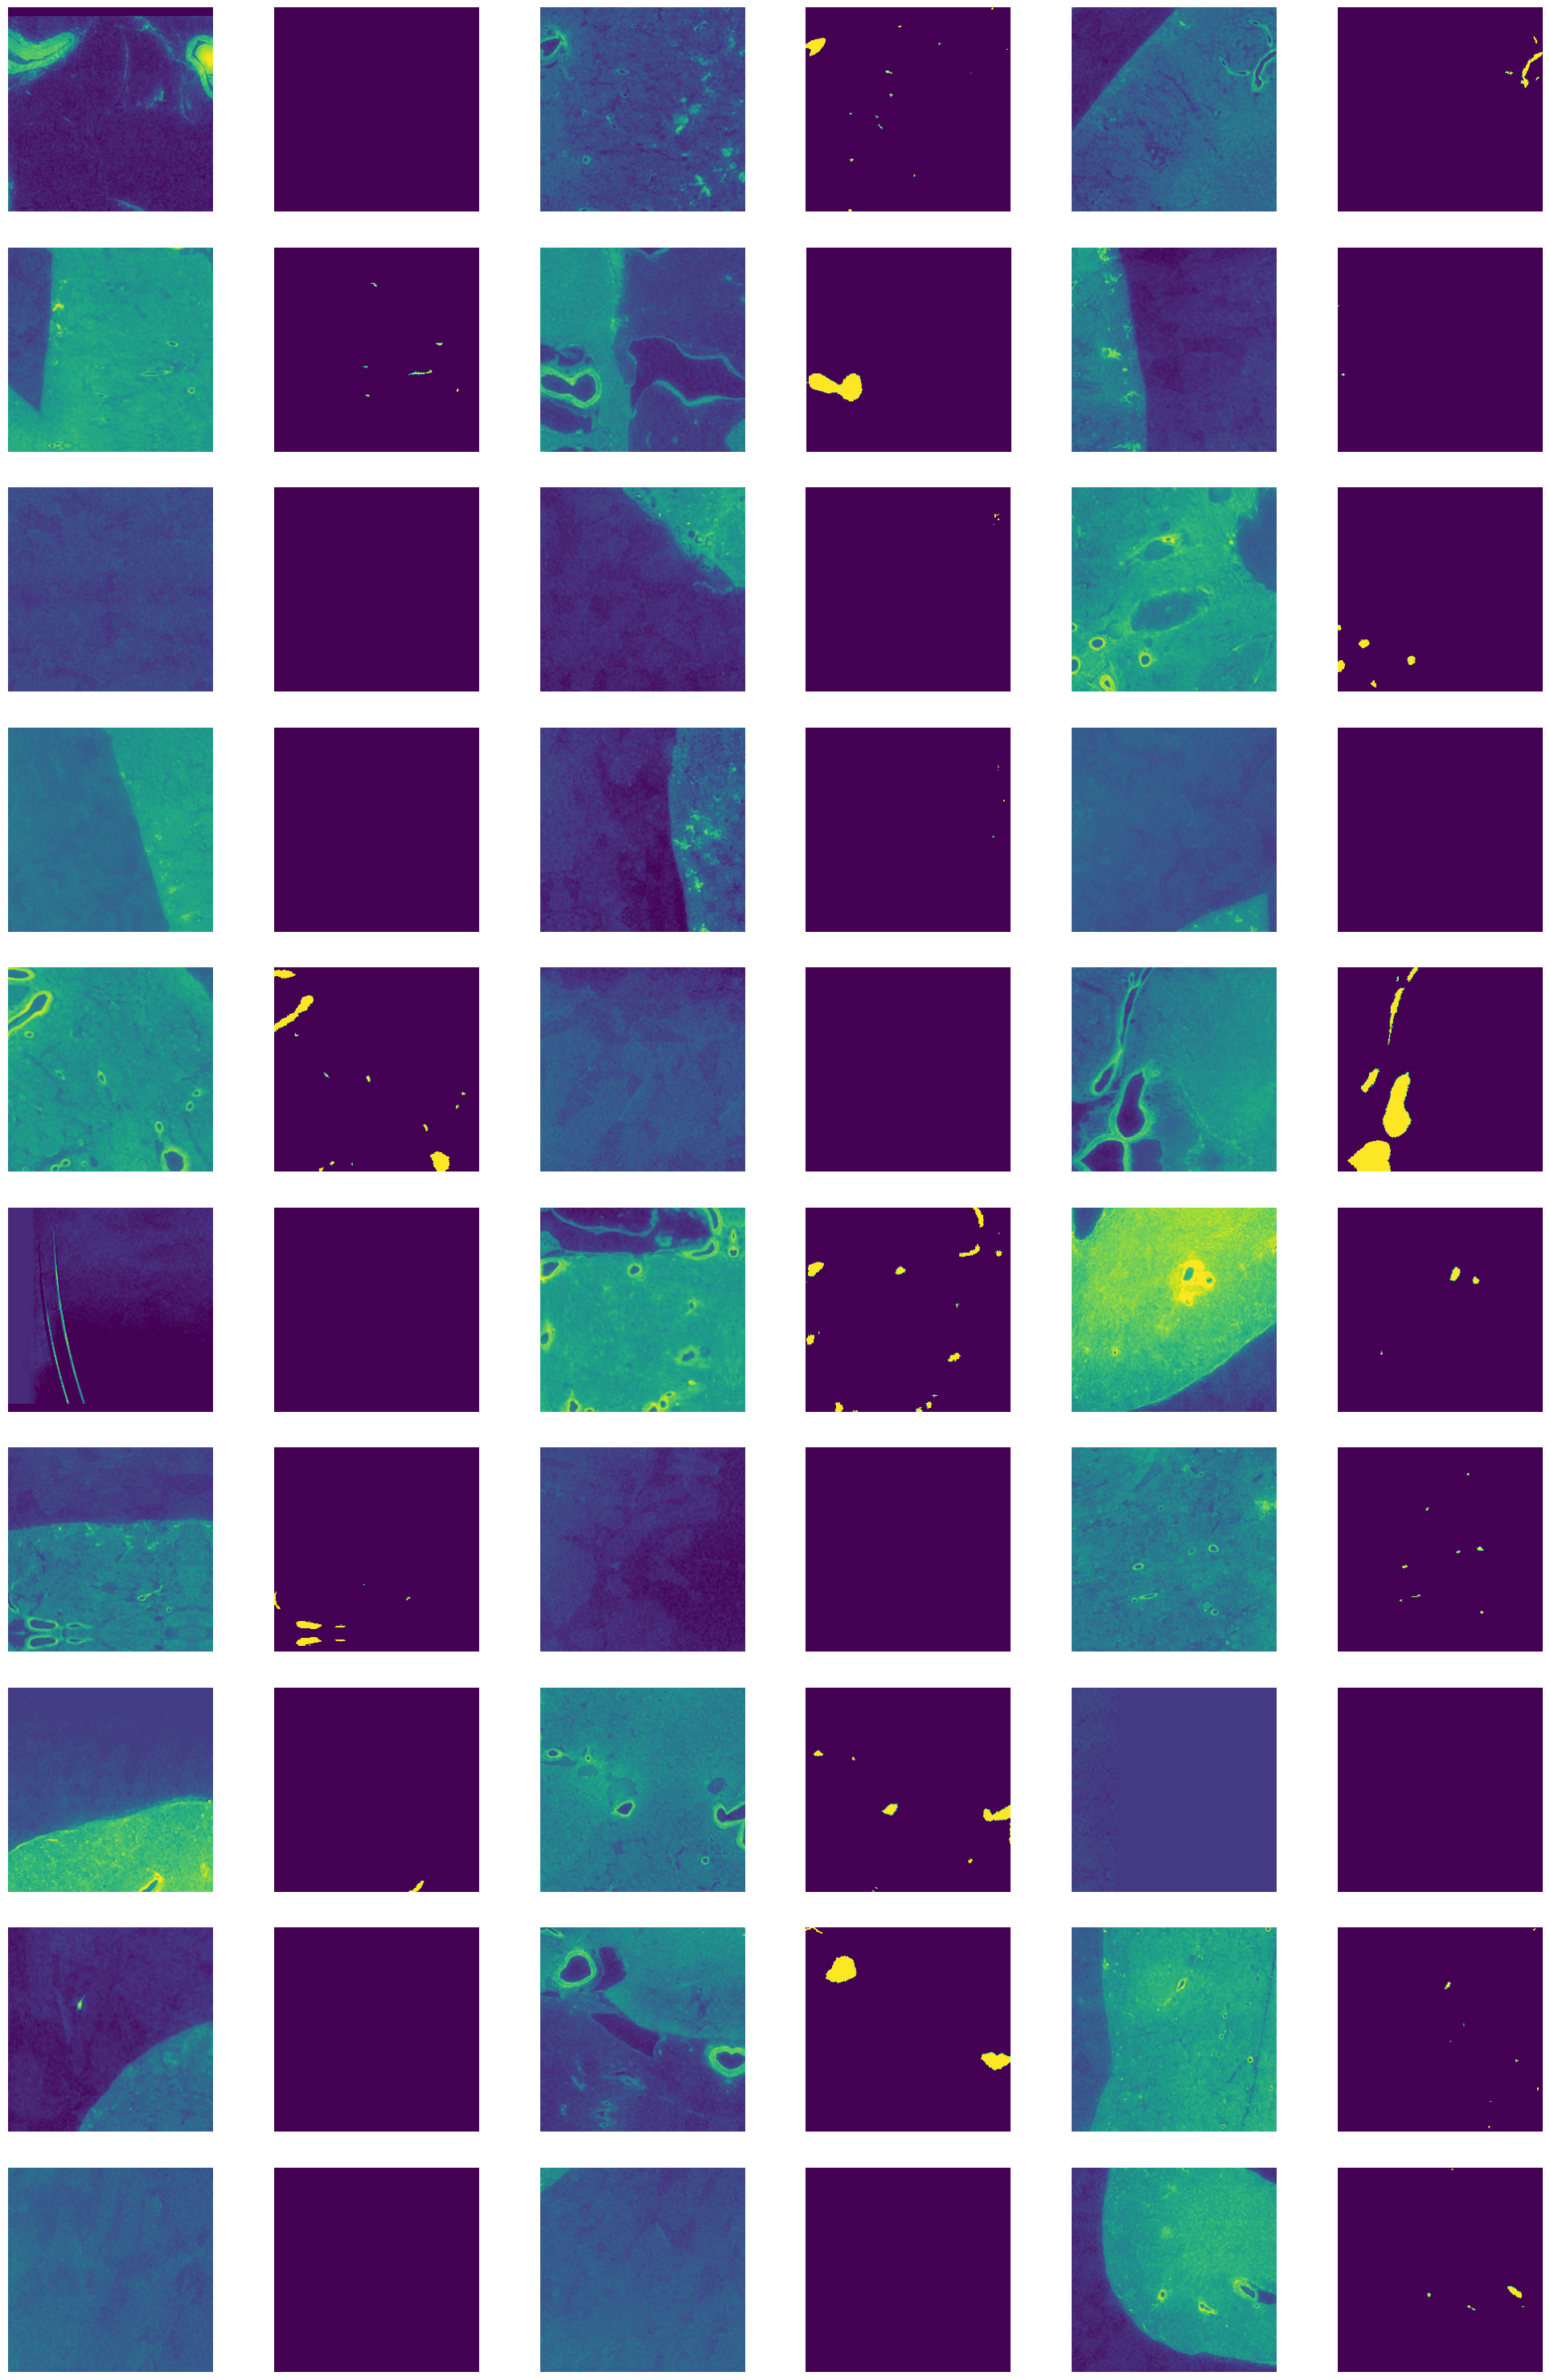

In [7]:
def filter_dataset(df):
    # trainのうちlabelが全くないものは90%の確率で除外
    df["random"] = np.random.rand(len(df))
    df = df[(df["sum"] > 0) | (df["fold0"] == "valid") | (df["random"] < cfg.negative_sample_rate)]
    df = df.reset_index(drop=True)
    df = df.drop(["random"], axis=1)
    return df


def mini_dataset(df):
    df["random"] = np.random.rand(len(df))
    df = df[df["random"] < 0.25]
    df = df.reset_index(drop=True)
    df = df.drop(["random"], axis=1)
    return df


df = pd.read_csv(f"{cfg.dataset_path}/dataset.csv")
df["axis"] = df["image_path"].str.split("/").str[-2].str.split("_").str[-1]
df = df[df["axis"] == "axis0"]
df = filter_dataset(df)
# df = mini_dataset(df)
if cfg.debug:
    df = df.sample(10000).reset_index(drop=True)
df["image_path"] = df["image_path"].str.replace("/kaggle/", "")
df["label_path"] = df["label_path"].str.replace("/kaggle/", "")
display(df)
if cfg.check_dataset:
    check_dataset(df, cfg)

In [8]:
if cfg.debug:
    print("!!!Debug mode!!!\n")
    cfg.epochs = 5

for fold in range(1):
    dataset = get_train_dataset(cfg)

    train_df = df[df[f"fold{fold}"] == "train"]
    valid_df = df[df[f"fold{fold}"] == "valid"]

    train_dataset = dataset(train_df, cfg, is_train=True)
    valid_dataset = dataset(valid_df, cfg, is_train=False)

    train_dataloader = DataLoader(train_dataset, batch_size=cfg.train_batch_size, num_workers=cfg.num_workers, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.valid_batch_size, num_workers=cfg.num_workers, shuffle=False)

    model = build_model(cfg.model_arch, cfg.backbone, cfg.in_chans, cfg.target_size)
    scaler = torch.cuda.amp.GradScaler()
    criterion = get_lossfn(cfg)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)
    scheduler = get_scheduler(cfg, optimizer)
    metrics = get_metrics(cfg)

    # model, scaler, criterion, optimizer, scheduler, metrics = init_model(cfg)
    slacknotify = init_exp(fold, cfg)

    path_best = f"./{cfg.exp_name}/{cfg.exp_name}_best_fold{fold}.pth"
    path_last = f"./{cfg.exp_name}/{cfg.exp_name}_last_fold{fold}.pth"

    best_loss = float("inf")
    for epoch in range(cfg.epochs):
        model.train()
        total_loss = 0.0
        pbar_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")

        for i, (images, masks) in pbar_train:
            images, masks = images.cuda(), masks.cuda()
            optimizer.zero_grad()

            with amp.autocast():
                preds = model(images)
                loss = criterion(preds, masks)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                total_loss += loss.detach().item()

            loss_ = total_loss / (i + 1)
            lr = f"LR : {scheduler.get_lr()[0]:.2E}"
            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{cfg.epochs}", gpu_mem, lr, f"Loss: {loss_:.4f}"))

        train_loss = loss_
        scheduler.step()
        wandb.log({"epoch": epoch, "train_loss": train_loss})

        model.eval()
        total_loss = 0.0
        pbar_val = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

        for i, (images, masks) in pbar_val:
            images, masks = images.cuda(), masks.cuda()
            with torch.no_grad():
                preds = model(images)
                loss = criterion(preds, masks)
                total_loss += loss.item()

            loss_ = total_loss / (i + 1)
            pbar_val.set_description(("%10s") % (f"Val Loss: {loss_:.4f}"))
        valid_loss = loss_
        wandb.log({"epoch": epoch, "valid_loss": valid_loss})

        if valid_loss < best_loss:
            print(f"loss : {valid_loss:.4f}\tSAVED MODEL\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {valid_loss:.4f}\tBEST")
            best_loss = valid_loss
            save_model(model, cfg, path_best, loss=loss)
        else:
            print(f"loss : {valid_loss:.4f}\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {valid_loss:.4f}")

    save_model(model, cfg, path_last, loss=valid_loss)
    wandb.config.update({"last_loss": valid_loss, "best_loss": best_loss})

    slacknotify.send_reply(f"{cfg.exp_name}_fold{fold} training finished\nbest loss : {best_loss:.4f} last loss : {loss_:.4f}", True)

    if wandb.run:
        wandb.finish()

model_arch:  Unet
backbone:  resnext101_32x8d


KeyError: 'SLACK_TOKEN'

In [ ]:
fold_dict = json.load(open("src/dataset/fold.json", "r"))

for fold in range(1):
    print(f"fold_{fold}")
    valid_kidney = fold_dict[f"fold{fold}"]["valid"][0]
    path_best = f"./{cfg.exp_name}/{cfg.exp_name}_best_fold{fold}.pth"
    model = load_inference_model(path_best, cfg)

    stack_path = f"working/dataset/stack_train01/{valid_kidney}_images.npy"
    label_path = f"working/dataset/stack_train01/{valid_kidney}_labels.npy"
    save_path = "./preds"
    preds_path = f"{save_path}/{valid_kidney}_preds.npy"
    inference(model, stack_path, save_path, cfg)

    label = np.load(label_path)
    preds = np.load(preds_path)
    thresh_score_dict = {}

    for thresh in np.arange(0.1, 0.99, 0.1):
        thresh = round(thresh, 5)
        thresh_score_dict[thresh] = compute_surface_dice_score_from_volume(ne.evaluate("preds > thresh"), label)

    max_score_thresh = max(thresh_score_dict, key=thresh_score_dict.get)

    for thresh in np.arange(max_score_thresh - 0.1, max_score_thresh + 0.1, 0.01):
        thresh = round(thresh, 5)
        thresh_score_dict[thresh] = compute_surface_dice_score_from_volume(ne.evaluate("preds > thresh"), label)

    print(max(thresh_score_dict.items(), key=lambda x: x[1]))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/src/dataset/fold.json'